In [22]:
import pandas as pd
stock_data=pd.read_csv("./BABA.csv",index_col='Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-06,215.320007,215.399994,209.373001,211.600006,211.600006,23719900
2021-07-07,211.610001,212.050003,207.820007,208.000000,208.000000,18340400
2021-07-08,201.710007,202.279999,198.259995,199.850006,199.850006,33992500
2021-07-09,202.050003,207.268005,201.500000,205.940002,205.940002,16911300
2021-07-12,203.899994,206.455002,203.020004,205.479996,205.479996,11259500


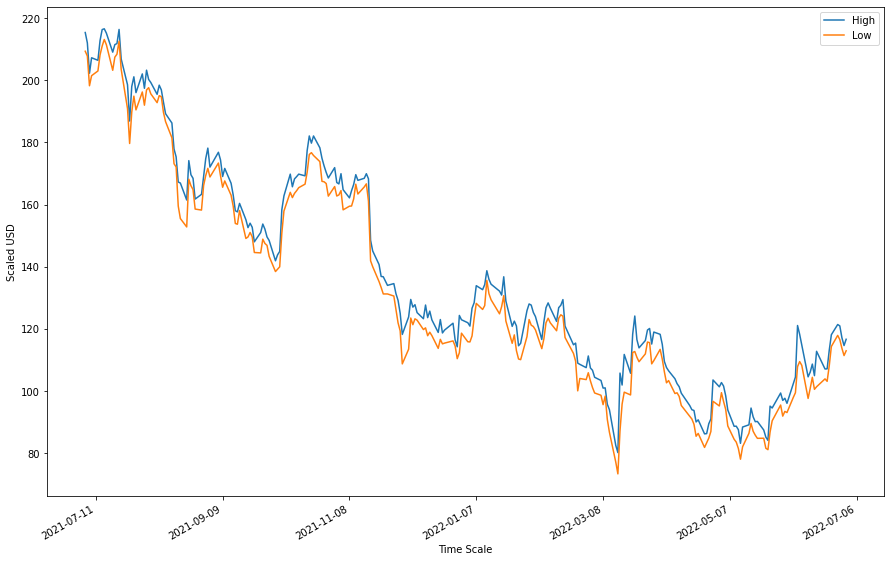

In [24]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates=[dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stock_data.index.values]

plt.plot(x_dates, stock_data['High'], label='High')
plt.plot(x_dates, stock_data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [3]:
#amazon ticker symbol Alibaba=BABA
import pandas_datareader as web
import datetime as dt

company = 'NDX'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,12,31)

df=web.DataReader(company,'yahoo',start,end)
df=df.reset_index()

In [9]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values
print(len(dataset))

train = dataset[0:2000,:]
valid = dataset[2000:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

2265
1940/1940 - 36s - loss: 4.6064e-04


/home/dragonwarrior/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


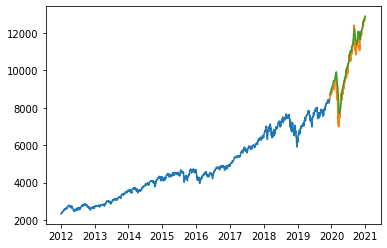

In [10]:
train = new_data[:2000]
valid = new_data[2000:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])